In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=500,wait_patient=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patient=wait_patient, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patient': [wait_patient], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 6 is added as ukc
ukc_6:, 75
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 10s 98ms/step - loss: 1.0953 - accuracy: 0.4688 - precision: 0.7907 - recall: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision: 0.5588 - val_recall: 0.2474
Epoch 2/14
100/100 [==============================] - 10s 95ms/step - loss: 0.9330 - accuracy: 0.5206 - precision: 0.6882 - recall: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision: 0.5249 - val_recall: 0.2474
Epoch 3/14
100/100 [==============================] - 10s 96ms/step - loss: 0.8765 - accuracy: 0.5734 - precision: 0.6923 - recall: 0.2503 - val_loss: 0.8578 - 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


epoch: 1/100, train_loss: 14.165757179260254, F1_train: 0.7046779003072088 F1_val: 0.6827613254983254


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.30it/s]


epoch: 2/100, train_loss: 14.165838241577148, F1_train: 0.7059725593384739 F1_val: 0.6858410429176557


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


epoch: 3/100, train_loss: 14.166088104248047, F1_train: 0.7063452206794599 F1_val: 0.7005797765525089


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


epoch: 4/100, train_loss: 14.165762901306152, F1_train: 0.7062245092635883 F1_val: 0.682228234973997


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


epoch: 5/100, train_loss: 14.165938377380371, F1_train: 0.7059516452884099 F1_val: 0.6953506353199175


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.30it/s]


epoch: 6/100, train_loss: 14.16569709777832, F1_train: 0.705644711660085 F1_val: 0.6899750422662035


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.29it/s]


epoch: 7/100, train_loss: 14.165853500366211, F1_train: 0.7056778513349036 F1_val: 0.6899750422662035


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


epoch: 8/100, train_loss: 14.166082382202148, F1_train: 0.7055257565574677 F1_val: 0.6874359911427321


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


epoch: 9/100, train_loss: 14.16580581665039, F1_train: 0.7839155446692536 F1_val: 0.9455729293643623


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


epoch: 10/100, train_loss: 14.165660858154297, F1_train: 0.7836134233790577 F1_val: 0.9453514407322886


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.34it/s]


epoch: 11/100, train_loss: 14.165657043457031, F1_train: 0.7834626429948969 F1_val: 0.9506591187535299


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


epoch: 12/100, train_loss: 14.165936470031738, F1_train: 0.7834626429948969 F1_val: 0.9452550841881524


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.31it/s]


epoch: 13/100, train_loss: 14.165802955627441, F1_train: 0.7833083715435553 F1_val: 0.9452331203793922


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


epoch: 14/100, train_loss: 14.165842056274414, F1_train: 0.7833083715435553 F1_val: 0.9424682890450476


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


epoch: 15/100, train_loss: 14.165970802307129, F1_train: 0.7833083715435553 F1_val: 0.9452342279462894


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


epoch: 16/100, train_loss: 14.165902137756348, F1_train: 0.7833083715435553 F1_val: 0.9424962945354397


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


epoch: 17/100, train_loss: 14.165745735168457, F1_train: 0.783157777538114 F1_val: 0.9452910808575017


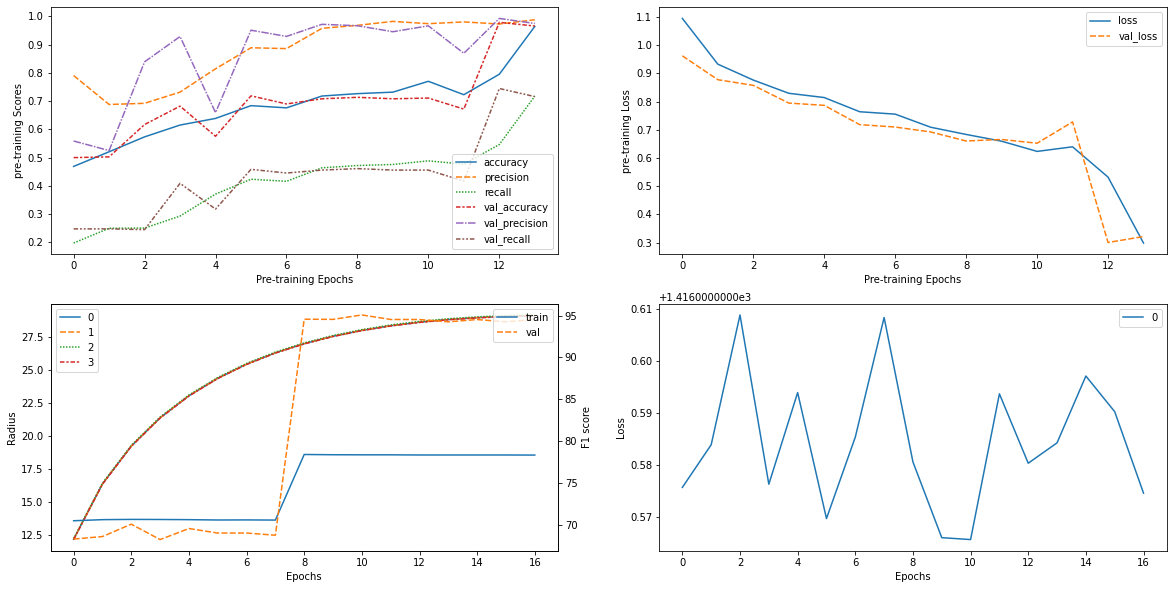

[[95  0  0  0  0]
 [ 0 93  0  0  0]
 [ 0  0 93  0  0]
 [ 0  0  0  2  0]
 [ 3  0 62  4  0]]
80.4
f1_weighted: 0.730890102449364, f1_macro: 0.6468911917098445, f1_micro: 0.8039772727272727, f_measure: {'Known': 80.8614, 'Open': 0, 'F1-score': 64.6891}
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        95
           1       1.00      1.00      1.00        93
           2       0.60      1.00      0.75        93
           3       0.33      1.00      0.50         2
           6       0.00      0.00      0.00        69

    accuracy                           0.80       352
   macro avg       0.58      0.80      0.65       352
weighted avg       0.69      0.80      0.73       352



In [2]:
comment="1000 data point dropped the f1, how is the status of ukc 6"
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=6,num_classes=4,embedding_size=2,
                             lr_rate=2, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=100, wait_patient=6, comment=comment, tracker_update=False)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 11s 99ms/step - loss: 1.0953 - accuracy: 0.4688 - precision_1: 0.7907 - recall_1: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision_1: 0.5588 - val_recall_1: 0.2474
Epoch 2/14
100/100 [==============================] - 10s 98ms/step - loss: 0.9330 - accuracy: 0.5206 - precision_1: 0.6882 - recall_1: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision_1: 0.5249 - val_recall_1: 0.2474
Epoch 3/14
100/100 [==============================] - 10s 104ms/step - loss: 0.8765 - accuracy: 0.5734 - precision_1: 0.6923 - recall_1: 0.2503

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.22it/s]


epoch: 1/100, train_loss: 14.165757179260254, F1_train: 0.7010149165722959 F1_val: 0.6768647127020141


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.56it/s]


epoch: 2/100, train_loss: 14.165838241577148, F1_train: 0.7050262176595103 F1_val: 0.6802988544764861


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


epoch: 3/100, train_loss: 14.166088104248047, F1_train: 0.7051472542100415 F1_val: 0.6955637251881429


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.60it/s]


epoch: 4/100, train_loss: 14.165762901306152, F1_train: 0.7061261774345298 F1_val: 0.6805620712199736


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


epoch: 5/100, train_loss: 14.165938377380371, F1_train: 0.7063452206794599 F1_val: 0.6936994485294118


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


epoch: 6/100, train_loss: 14.16569709777832, F1_train: 0.7063452206794599 F1_val: 0.688304314803621


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.51it/s]


epoch: 7/100, train_loss: 14.165853500366211, F1_train: 0.7063452206794599 F1_val: 0.6899750422662035


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.93it/s]


epoch: 8/100, train_loss: 14.166082382202148, F1_train: 0.7065311708244175 F1_val: 0.6874359911427321


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]


epoch: 9/100, train_loss: 14.16580581665039, F1_train: 0.7065311708244175 F1_val: 0.6929687626976957


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


epoch: 10/100, train_loss: 14.165660858154297, F1_train: 0.7063777443916134 F1_val: 0.6875389407322886


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.42it/s]


epoch: 11/100, train_loss: 14.165657043457031, F1_train: 0.7062245092635883 F1_val: 0.7006591187535297


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.46it/s]


epoch: 12/100, train_loss: 14.165936470031738, F1_train: 0.7062245092635883 F1_val: 0.697859250854819


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


epoch: 13/100, train_loss: 14.165802955627441, F1_train: 0.7062245092635883 F1_val: 0.7004414537127256


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.16it/s]


epoch: 14/100, train_loss: 14.165842056274414, F1_train: 0.7062245092635883 F1_val: 0.6898641223783809


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.57it/s]


epoch: 15/100, train_loss: 14.165970802307129, F1_train: 0.7062245092635883 F1_val: 0.6900258946129559


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.62it/s]


epoch: 16/100, train_loss: 14.165902137756348, F1_train: 0.7062245092635883 F1_val: 0.7003087945354397


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.41it/s]


epoch: 17/100, train_loss: 14.165745735168457, F1_train: 0.7060714650827629 F1_val: 0.6926869141908351


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.52it/s]


epoch: 18/100, train_loss: 14.16581916809082, F1_train: 0.7060714650827629 F1_val: 0.6952695600538855


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


epoch: 19/100, train_loss: 14.165921211242676, F1_train: 0.7060714650827629 F1_val: 0.68739241242474


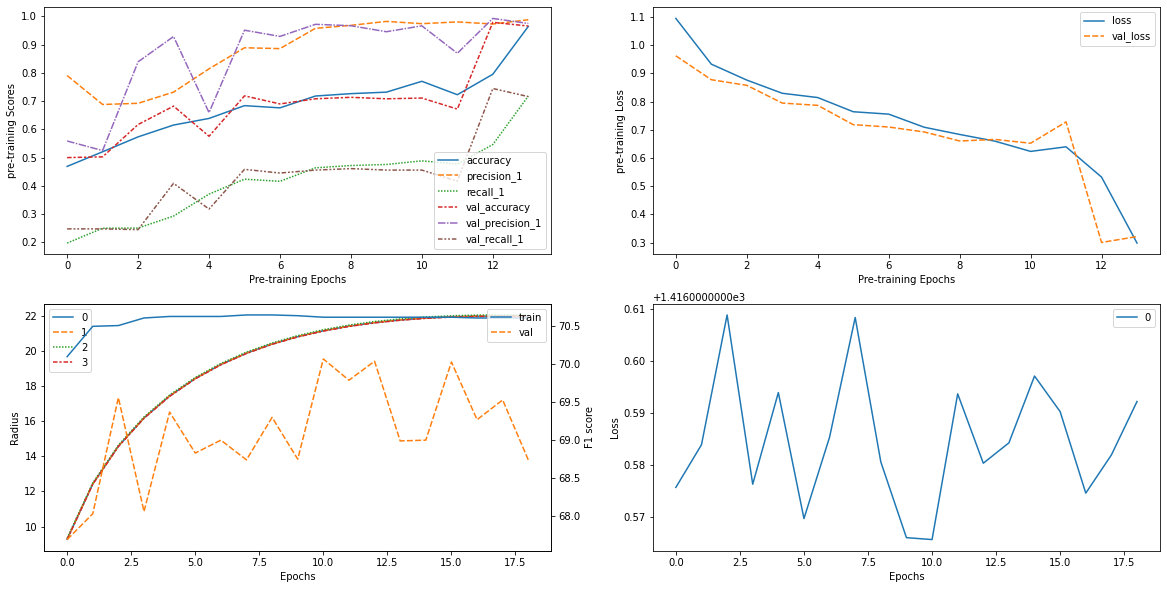

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [39  0 35  1 20]]
56.51
f1_weighted: 0.47882377766810996, f1_macro: 0.5348881680439472, f1_micro: 0.5651041666666666, f_measure: {'Known': 62.0301, 'Open': 19.3237, 'F1-score': 53.4888}
              precision    recall  f1-score   support

           0       0.72      1.00      0.83        98
           1       0.00      0.00      0.00        92
           2       0.73      1.00      0.85        97
           3       0.67      1.00      0.80         2
           5       0.18      0.21      0.19        95

    accuracy                           0.57       384
   macro avg       0.46      0.64      0.53       384
weighted avg       0.42      0.57      0.48       384



In [3]:
comment="going back to ukc5 but lower LR "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=1.5, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=100, wait_patient=8, comment=comment, tracker_update=True)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 11s 109ms/step - loss: 1.0953 - accuracy: 0.4688 - precision_2: 0.7907 - recall_2: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision_2: 0.5588 - val_recall_2: 0.2474
Epoch 2/14
100/100 [==============================] - 10s 97ms/step - loss: 0.9330 - accuracy: 0.5206 - precision_2: 0.6882 - recall_2: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision_2: 0.5249 - val_recall_2: 0.2474
Epoch 3/14
100/100 [==============================] - 10s 101ms/step - loss: 0.8765 - accuracy: 0.5734 - precision_2: 0.6923 - recall_2: 0.250

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.49it/s]


epoch: 1/100, train_loss: 14.165757179260254, F1_train: 0.7054559358949362 F1_val: 0.6866446284037308


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.58it/s]


epoch: 2/100, train_loss: 14.165838241577148, F1_train: 0.7065311708244175 F1_val: 0.6874984089890844


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.61it/s]


epoch: 3/100, train_loss: 14.166088104248047, F1_train: 0.7057971851358922 F1_val: 0.7005797765525089


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.72it/s]


epoch: 4/100, train_loss: 14.165762901306152, F1_train: 0.7052221331121893 F1_val: 0.682228234973997


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


epoch: 5/100, train_loss: 14.165938377380371, F1_train: 0.7833083715435553 F1_val: 0.9453506353199175


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


epoch: 6/100, train_loss: 14.16569709777832, F1_train: 0.7845580896329244 F1_val: 0.9425792089328703


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  5.99it/s]


epoch: 7/100, train_loss: 14.165853500366211, F1_train: 0.7848052338179018 F1_val: 0.9425792089328703


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:18<00:00,  5.28it/s]


epoch: 8/100, train_loss: 14.166082382202148, F1_train: 0.784627571487588 F1_val: 0.9426443244760655


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


epoch: 9/100, train_loss: 14.16580581665039, F1_train: 0.7853269692433819 F1_val: 0.9455729293643623


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.67it/s]


epoch: 10/100, train_loss: 14.165660858154297, F1_train: 0.7853008392181464 F1_val: 0.9453514407322886


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.02it/s]


epoch: 11/100, train_loss: 14.165657043457031, F1_train: 0.7849778234852982 F1_val: 0.9506591187535299


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


epoch: 12/100, train_loss: 14.165936470031738, F1_train: 0.78408232353062 F1_val: 0.9452550841881524


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


epoch: 13/100, train_loss: 14.165802955627441, F1_train: 0.7843577878809839 F1_val: 0.9452331203793922


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.09it/s]


epoch: 14/100, train_loss: 14.165842056274414, F1_train: 0.7840589073263223 F1_val: 0.9424682890450476


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.30it/s]


epoch: 15/100, train_loss: 14.165970802307129, F1_train: 0.7840589073263223 F1_val: 0.9452342279462894


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.33it/s]


epoch: 16/100, train_loss: 14.165902137756348, F1_train: 0.7847550712766989 F1_val: 0.9424962945354397


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s]


epoch: 17/100, train_loss: 14.165745735168457, F1_train: 0.7847550712766989 F1_val: 0.9452910808575017


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.27it/s]


epoch: 18/100, train_loss: 14.16581916809082, F1_train: 0.7847550712766989 F1_val: 0.9426653933872187


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


epoch: 19/100, train_loss: 14.165921211242676, F1_train: 0.7847550712766989 F1_val: 0.9426007457580733


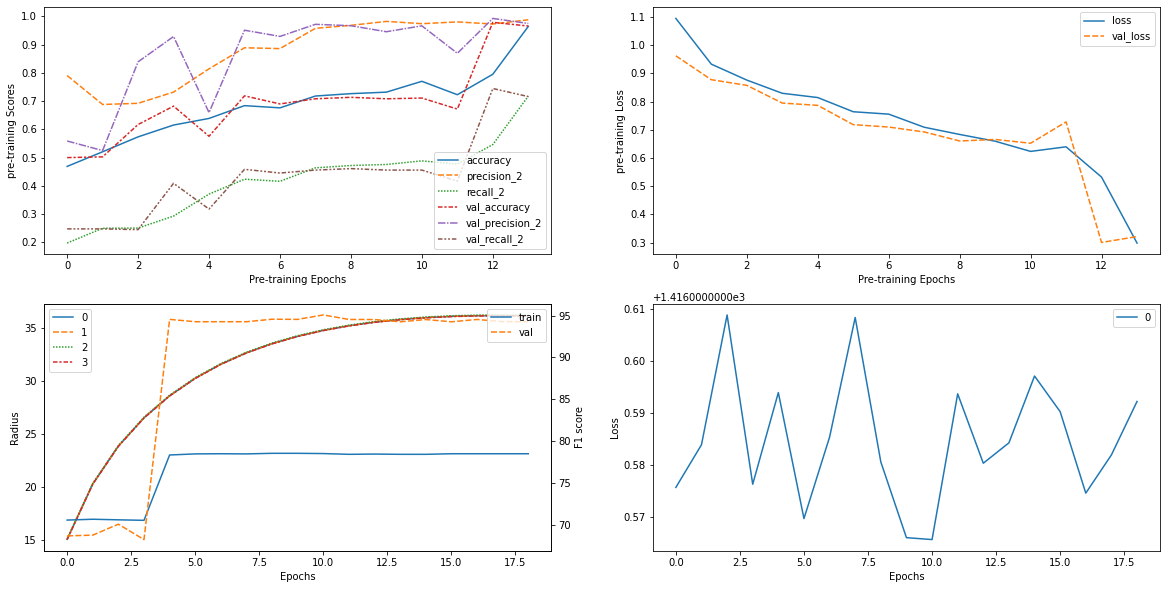

[[98  0  0  0  0]
 [ 0 92  0  0  0]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [58  0 35  2  0]]
75.26
f1_weighted: 0.6539845131940385, f1_macro: 0.657096356405231, f1_micro: 0.7526041666666665, f_measure: {'Known': 82.137, 'Open': 0, 'F1-score': 65.7096}
              precision    recall  f1-score   support

           0       0.63      1.00      0.77        98
           1       1.00      1.00      1.00        92
           2       0.73      1.00      0.85        97
           3       0.50      1.00      0.67         2
           5       0.00      0.00      0.00        95

    accuracy                           0.75       384
   macro avg       0.57      0.80      0.66       384
weighted avg       0.59      0.75      0.65       384



In [4]:
comment="going back to ukc5 but lower LR"
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=2.5, optimizer='nadam',
pretrain_epochs=14,octrain_epochs=100, wait_patient=8, comment=comment, tracker_update=True)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 10s 98ms/step - loss: 1.0953 - accuracy: 0.4688 - precision_3: 0.7907 - recall_3: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision_3: 0.5588 - val_recall_3: 0.2474
Epoch 2/14
100/100 [==============================] - 10s 102ms/step - loss: 0.9330 - accuracy: 0.5206 - precision_3: 0.6882 - recall_3: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision_3: 0.5249 - val_recall_3: 0.2474
Epoch 3/14
100/100 [==============================] - 9s 95ms/step - loss: 0.8765 - accuracy: 0.5734 - precision_3: 0.6923 - recall_3: 0.2503 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.05it/s]


epoch: 1/100, train_loss: 14.165757179260254, F1_train: 0.5717538550140628 F1_val: 0.5624149611789537


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


epoch: 2/100, train_loss: 14.165838241577148, F1_train: 0.6032044632692126 F1_val: 0.5695404103852596


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.79it/s]


epoch: 3/100, train_loss: 14.166088104248047, F1_train: 0.6260338487112843 F1_val: 0.591338180651937


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


epoch: 4/100, train_loss: 14.165762901306152, F1_train: 0.6422175286482105 F1_val: 0.6101960893124773


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.73it/s]


epoch: 5/100, train_loss: 14.165938377380371, F1_train: 0.6533321312466783 F1_val: 0.6436196972443801


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.93it/s]


epoch: 6/100, train_loss: 14.16569709777832, F1_train: 0.6600795718679302 F1_val: 0.6482194170771757


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.88it/s]


epoch: 7/100, train_loss: 14.165853500366211, F1_train: 0.6684101596619715 F1_val: 0.6527856271228378


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.13it/s]


epoch: 8/100, train_loss: 14.166082382202148, F1_train: 0.6711787565068409 F1_val: 0.6633478979561068


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


epoch: 9/100, train_loss: 14.16580581665039, F1_train: 0.6748743268523555 F1_val: 0.6680050687423099


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


epoch: 10/100, train_loss: 14.165660858154297, F1_train: 0.6781475335385951 F1_val: 0.6637839795008913


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.09it/s]


epoch: 11/100, train_loss: 14.165657043457031, F1_train: 0.6813525125097375 F1_val: 0.6797723760614386


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


epoch: 12/100, train_loss: 14.165936470031738, F1_train: 0.6826425512065271 F1_val: 0.6782031896195203


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.26it/s]


epoch: 13/100, train_loss: 14.165802955627441, F1_train: 0.6845189612292593 F1_val: 0.6795165529980108


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.25it/s]


epoch: 14/100, train_loss: 14.165842056274414, F1_train: 0.6862095544570639 F1_val: 0.6735652011125376


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.25it/s]


epoch: 15/100, train_loss: 14.165970802307129, F1_train: 0.6881691739035909 F1_val: 0.6769272387868345


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.09it/s]


epoch: 16/100, train_loss: 14.165902137756348, F1_train: 0.6896831616048158 F1_val: 0.6869896778719847


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


epoch: 17/100, train_loss: 14.165745735168457, F1_train: 0.6919855000891982 F1_val: 0.6814580512521778


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


epoch: 18/100, train_loss: 14.16581916809082, F1_train: 0.6918491162179311 F1_val: 0.6838750323498965


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


epoch: 19/100, train_loss: 14.165921211242676, F1_train: 0.6917858044531371 F1_val: 0.6747322233513641


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.22it/s]


epoch: 20/100, train_loss: 14.165799140930176, F1_train: 0.6922750250784526 F1_val: 0.682615240067495


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 21/100, train_loss: 14.165776252746582, F1_train: 0.6923988232342251 F1_val: 0.6832374929566128


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.15it/s]


epoch: 22/100, train_loss: 14.165743827819824, F1_train: 0.6926060009046157 F1_val: 0.6882425742574257


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


epoch: 23/100, train_loss: 14.165879249572754, F1_train: 0.6928128806919434 F1_val: 0.6843691957886661


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 24/100, train_loss: 14.165901184082031, F1_train: 0.6925418575745873 F1_val: 0.6810551730732453


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


epoch: 25/100, train_loss: 14.16577434539795, F1_train: 0.6928194510023559 F1_val: 0.6861673722230853


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s]


epoch: 26/100, train_loss: 14.165745735168457, F1_train: 0.6928194510023559 F1_val: 0.6776875680827886


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.89it/s]


epoch: 27/100, train_loss: 14.165897369384766, F1_train: 0.6928194510023559 F1_val: 0.6836361065972536


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


epoch: 28/100, train_loss: 14.165655136108398, F1_train: 0.693436535606712 F1_val: 0.6853910839743201


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


epoch: 29/100, train_loss: 14.165935516357422, F1_train: 0.6938464539919615 F1_val: 0.6844355620155039


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.28it/s]


epoch: 30/100, train_loss: 14.165938377380371, F1_train: 0.6942552011818246 F1_val: 0.6745192307692308


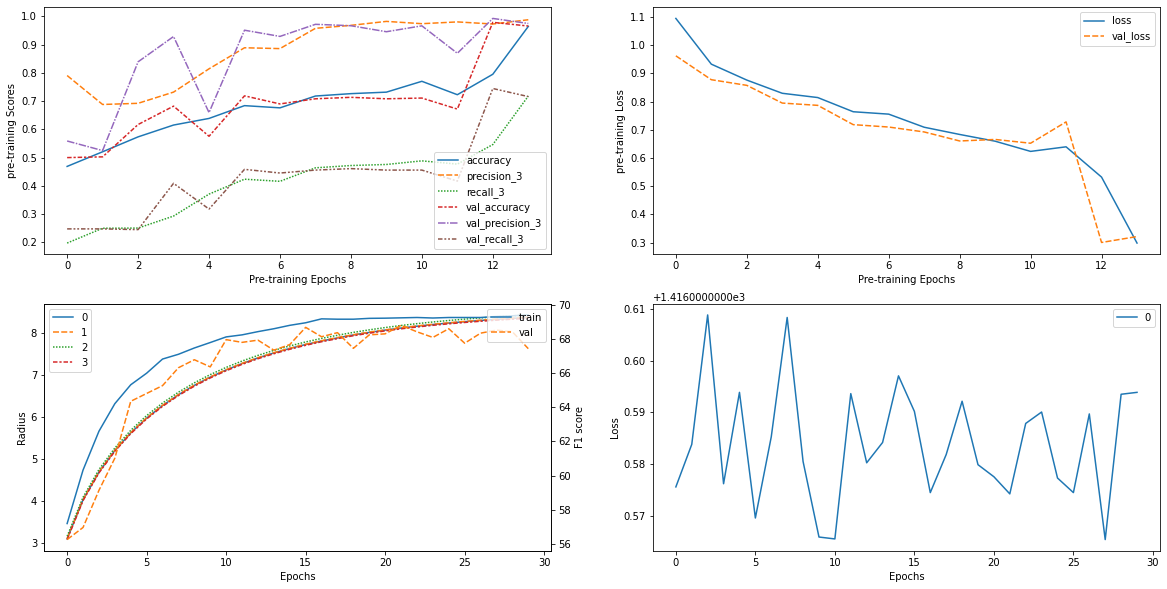

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [19  0 18  0 58]]
66.41
f1_weighted: 0.5861543689162808, f1_macro: 0.6600383268708975, f1_micro: 0.6640625, f_measure: {'Known': 70.6681, 'Open': 47.3469, 'F1-score': 66.0038}
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        98
           1       0.00      0.00      0.00        92
           2       0.84      1.00      0.92        97
           3       1.00      1.00      1.00         2
           5       0.39      0.61      0.47        95

    accuracy                           0.66       384
   macro avg       0.61      0.72      0.66       384
weighted avg       0.53      0.66      0.59       384



In [5]:
comment="with adam "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=14,octrain_epochs=100, wait_patient=8, comment=comment, tracker_update=True)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 10s 96ms/step - loss: 1.0953 - accuracy: 0.4688 - precision: 0.7907 - recall: 0.1972 - val_loss: 0.9625 - val_accuracy: 0.5000 - val_precision: 0.5588 - val_recall: 0.2474
Epoch 2/14
100/100 [==============================] - 9s 94ms/step - loss: 0.9330 - accuracy: 0.5206 - precision: 0.6882 - recall: 0.2497 - val_loss: 0.8779 - val_accuracy: 0.5026 - val_precision: 0.5249 - val_recall: 0.2474
Epoch 3/14
100/100 [==============================] - 9s 94ms/step - loss: 0.8765 - accuracy: 0.5734 - precision: 0.6923 - recall: 0.2503 - val_loss: 0.8578 - v

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.47it/s]


epoch: 1/500, train_loss: 14.165757179260254, F1_train: 0.5894842159101522 F1_val: 0.56497710581869


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.60it/s]


epoch: 2/500, train_loss: 14.165838241577148, F1_train: 0.6266581546586569 F1_val: 0.57739674443642


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


epoch: 3/500, train_loss: 14.166088104248047, F1_train: 0.6493368952186942 F1_val: 0.6443462643678162


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


epoch: 4/500, train_loss: 14.165762901306152, F1_train: 0.6636023043001543 F1_val: 0.640703091278766


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


epoch: 5/500, train_loss: 14.165938377380371, F1_train: 0.6718578337341132 F1_val: 0.667441174994983


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


epoch: 6/500, train_loss: 14.16569709777832, F1_train: 0.6798351876650786 F1_val: 0.6657632767262985


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


epoch: 7/500, train_loss: 14.165853500366211, F1_train: 0.6845189612292593 F1_val: 0.6718753310556703


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.50it/s]


epoch: 8/500, train_loss: 14.166082382202148, F1_train: 0.6895212004286464 F1_val: 0.6760498982739889


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.55it/s]


epoch: 9/500, train_loss: 14.16580581665039, F1_train: 0.692066949888402 F1_val: 0.6794106598045774


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


epoch: 10/500, train_loss: 14.165660858154297, F1_train: 0.6925418575745873 F1_val: 0.6741138059701494


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


epoch: 11/500, train_loss: 14.165657043457031, F1_train: 0.6948661369317481 F1_val: 0.6865879274764151


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


epoch: 12/500, train_loss: 14.165936470031738, F1_train: 0.6964010138620048 F1_val: 0.6833431603773586


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.51it/s]


epoch: 13/500, train_loss: 14.165802955627441, F1_train: 0.6978646010916311 F1_val: 0.6847508536304917


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.52it/s]


epoch: 14/500, train_loss: 14.165842056274414, F1_train: 0.6983881528979734 F1_val: 0.6727670495082302


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.53it/s]


epoch: 15/500, train_loss: 14.165970802307129, F1_train: 0.6991408613214094 F1_val: 0.6732386578496935


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.49it/s]


epoch: 16/500, train_loss: 14.165902137756348, F1_train: 0.6995253221403024 F1_val: 0.683352262846709


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.35it/s]


epoch: 17/500, train_loss: 14.165745735168457, F1_train: 0.7008197176841486 F1_val: 0.6796195514765372


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.43it/s]


epoch: 18/500, train_loss: 14.16581916809082, F1_train: 0.7010149165722959 F1_val: 0.6821162370941195


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.54it/s]


epoch: 19/500, train_loss: 14.165921211242676, F1_train: 0.7014044976168405 F1_val: 0.6741332030806251


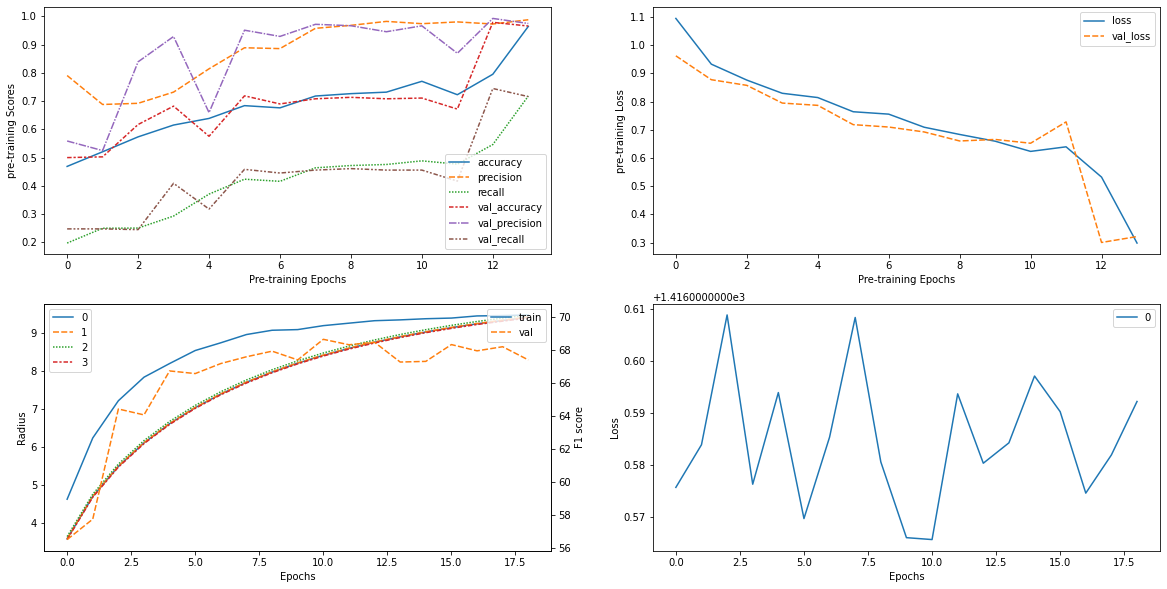

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [21  0 18  0 56]]
65.89
f1_weighted: 0.5809017922034035, f1_macro: 0.6558450991736986, f1_micro: 0.6588541666666666, f_measure: {'Known': 70.458, 'Open': 46.0905, 'F1-score': 65.5845}
              precision    recall  f1-score   support

           0       0.82      1.00      0.90        98
           1       0.00      0.00      0.00        92
           2       0.84      1.00      0.92        97
           3       1.00      1.00      1.00         2
           5       0.38      0.59      0.46        95

    accuracy                           0.66       384
   macro avg       0.61      0.72      0.66       384
weighted avg       0.52      0.66      0.58       384



In [2]:
comment="adam performs better when data is 1000, lets increse the lr a bit "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=2,
                             lr_rate=3, optimizer='adam',
pretrain_epochs=14, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/14
100/100 [==============================] - 11s 99ms/step - loss: 0.7695 - accuracy: 0.4941 - precision_1: 0.9020 - recall_1: 0.4284 - val_loss: 0.5616 - val_accuracy: 0.5208 - val_precision_1: 0.9458 - val_recall_1: 0.5000
Epoch 2/14
100/100 [==============================] - 10s 98ms/step - loss: 0.4631 - accuracy: 0.9181 - precision_1: 0.9862 - recall_1: 0.6697 - val_loss: 0.3287 - val_accuracy: 0.9974 - val_precision_1: 1.0000 - val_recall_1: 0.7474
Epoch 3/14
100/100 [==============================] - 10s 101ms/step - loss: 0.3359 - accuracy: 0.9759 - precision_1: 0.9882 - recall_1: 0.7334

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


epoch: 1/500, train_loss: 4.202226638793945, F1_train: 0.6207456670553624 F1_val: 0.5792335716224383


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


epoch: 2/500, train_loss: 4.202341079711914, F1_train: 0.6794767226053412 F1_val: 0.613832279999856


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.20it/s]


epoch: 3/500, train_loss: 4.20242166519165, F1_train: 0.7049731890491234 F1_val: 0.6561082766439909


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.20it/s]


epoch: 4/500, train_loss: 4.202204704284668, F1_train: 0.7278323807797179 F1_val: 0.6477431778629664


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


epoch: 5/500, train_loss: 4.2023515701293945, F1_train: 0.7526647034705192 F1_val: 0.668316448829955


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.04it/s]


epoch: 6/500, train_loss: 4.20211124420166, F1_train: 0.7773496324692479 F1_val: 0.6670196900003523


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.07it/s]


epoch: 7/500, train_loss: 4.202343463897705, F1_train: 0.796701846679349 F1_val: 0.6798248120491719


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.92it/s]


epoch: 8/500, train_loss: 4.202490329742432, F1_train: 0.8476606160894343 F1_val: 0.677388303636773


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


epoch: 9/500, train_loss: 4.202286243438721, F1_train: 0.8616102474215416 F1_val: 0.6892780709941108


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


epoch: 10/500, train_loss: 4.202166557312012, F1_train: 0.8732447713935139 F1_val: 0.6858475130890053


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.18it/s]


epoch: 11/500, train_loss: 4.2020158767700195, F1_train: 0.8797877157686983 F1_val: 0.6935444531915778


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 12/500, train_loss: 4.202330112457275, F1_train: 0.884607186769328 F1_val: 0.6950237211221122


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]


epoch: 13/500, train_loss: 4.202183723449707, F1_train: 0.8874793109034484 F1_val: 0.6993958005765198


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


epoch: 14/500, train_loss: 4.2023024559021, F1_train: 0.8897416721551334 F1_val: 0.6987680571240354


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.16it/s]


epoch: 15/500, train_loss: 4.2024946212768555, F1_train: 0.8914955187769752 F1_val: 0.6962338637525564


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76it/s]


epoch: 16/500, train_loss: 4.202366352081299, F1_train: 0.892596288726627 F1_val: 0.706891273168579


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


epoch: 17/500, train_loss: 4.202117443084717, F1_train: 0.8942570092852242 F1_val: 0.7016362644455373


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.12it/s]


epoch: 18/500, train_loss: 4.202333450317383, F1_train: 0.8949955851035171 F1_val: 0.7017768586538263


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


epoch: 19/500, train_loss: 4.202254772186279, F1_train: 0.895474159211392 F1_val: 0.6938293498636674


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


epoch: 20/500, train_loss: 4.202280044555664, F1_train: 0.8965813253788335 F1_val: 0.7034517489148513


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.11it/s]


epoch: 21/500, train_loss: 4.202108860015869, F1_train: 0.8981147690730882 F1_val: 0.6992355744072777


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


epoch: 22/500, train_loss: 4.202208995819092, F1_train: 0.8989460242684331 F1_val: 0.7072643136649162


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.10it/s]


epoch: 23/500, train_loss: 4.202342987060547, F1_train: 0.8992794777707053 F1_val: 0.7016203633400151


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.19it/s]


epoch: 24/500, train_loss: 4.2023444175720215, F1_train: 0.9002802984961654 F1_val: 0.6992886377453535


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.05it/s]


epoch: 25/500, train_loss: 4.202321529388428, F1_train: 0.9006130928455712 F1_val: 0.7084859006734007


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.08it/s]


epoch: 26/500, train_loss: 4.202212333679199, F1_train: 0.900786337015905 F1_val: 0.6947957830002784


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 27/500, train_loss: 4.202354907989502, F1_train: 0.9012396209438386 F1_val: 0.7083493949600799


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 28/500, train_loss: 4.202172756195068, F1_train: 0.901431516043059 F1_val: 0.7024511404361297


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.23it/s]


epoch: 29/500, train_loss: 4.202458381652832, F1_train: 0.90160385169086 F1_val: 0.7068738553113553


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


epoch: 30/500, train_loss: 4.202391624450684, F1_train: 0.9017759613246967 F1_val: 0.6980138036809818


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.24it/s]


epoch: 31/500, train_loss: 4.202348232269287, F1_train: 0.9017759613246967 F1_val: 0.6989603260003188


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.80it/s]


epoch: 32/500, train_loss: 4.202259540557861, F1_train: 0.9017759613246967 F1_val: 0.7053358891258394


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.36it/s]


epoch: 33/500, train_loss: 4.202345848083496, F1_train: 0.9019478453888954 F1_val: 0.7001396917148363


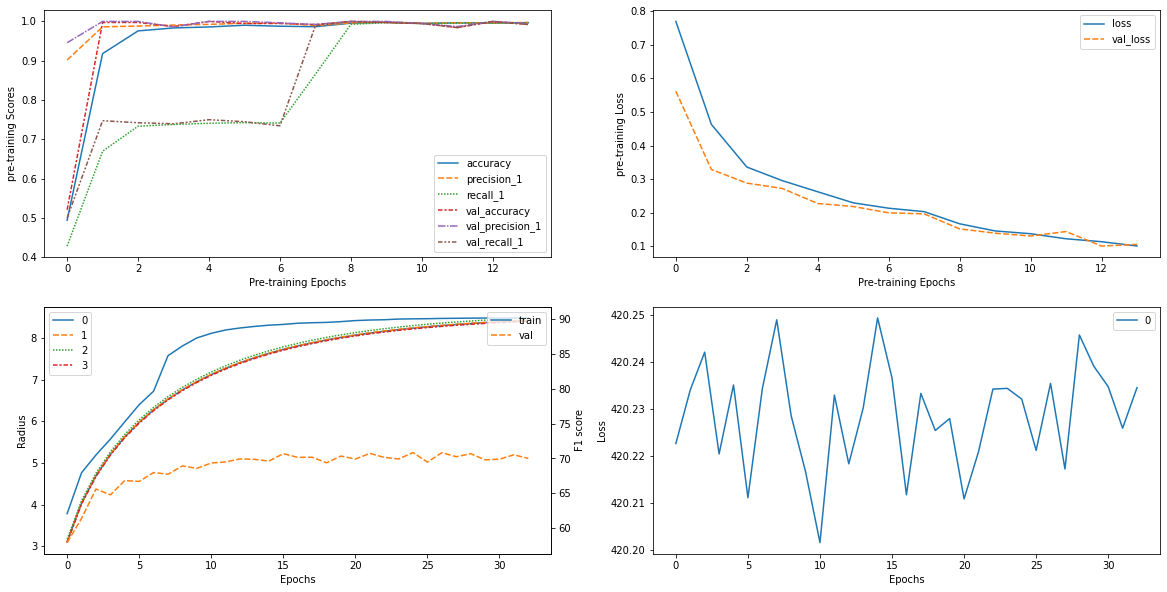

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [ 0  0 19  1 75]]
70.83
f1_weighted: 0.6310852365038407, f1_macro: 0.6566634412070387, f1_micro: 0.7083333333333334, f_measure: {'Known': 67.77, 'Open': 57.2519, 'F1-score': 65.6663}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.00      0.00      0.00        92
           2       0.84      1.00      0.91        97
           3       0.67      1.00      0.80         2
           5       0.45      0.79      0.57        95

    accuracy                           0.71       384
   macro avg       0.59      0.76      0.66       384
weighted avg       0.58      0.71      0.63       384



In [3]:
# restart the kernel to reload opensetv6 for the epoch number while breaking
comment="what about increasing embedding size=4 "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=4,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=14, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 800
val_0:, 100
test_0:, 100
train_1:, 800
val_1:, 100
test_1:, 100
train_2:, 800
val_2:, 100
test_2:, 100
train_3:, 800
val_3:, 100
test_3:, 2
class 5 is added as ukc
ukc_5:, 100
vocab_size: 50
Epoch 1/16
100/100 [==============================] - 11s 101ms/step - loss: 0.7695 - accuracy: 0.4941 - precision_3: 0.9020 - recall_3: 0.4284 - val_loss: 0.5616 - val_accuracy: 0.5208 - val_precision_3: 0.9458 - val_recall_3: 0.5000
Epoch 2/16
100/100 [==============================] - 10s 99ms/step - loss: 0.4631 - accuracy: 0.9181 - precision_3: 0.9862 - recall_3: 0.6697 - val_loss: 0.3287 - val_accuracy: 0.9974 - val_precision_3: 1.0000 - val_recall_3: 0.7474
Epoch 3/16
100/100 [==============================] - 10s 100ms/step - loss: 0.3359 - accuracy: 0.9759 - precision_3: 0.9882 - recall_3: 0.733

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.86it/s]


epoch: 1/500, train_loss: 3.6619155406951904, F1_train: 0.7589074207342864 F1_val: 0.5906482390541444


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.98it/s]


epoch: 2/500, train_loss: 3.662076950073242, F1_train: 0.7889109690023578 F1_val: 0.6058566647512025


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 3/500, train_loss: 3.6617515087127686, F1_train: 0.8052233641959458 F1_val: 0.615148186237846


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.98it/s]


epoch: 4/500, train_loss: 3.6619603633880615, F1_train: 0.8421747603047964 F1_val: 0.6220150795333683


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]


epoch: 5/500, train_loss: 3.6616814136505127, F1_train: 0.8511117132939936 F1_val: 0.6383723917807864


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.74it/s]


epoch: 6/500, train_loss: 3.6618902683258057, F1_train: 0.8555133666386321 F1_val: 0.6366698607634543


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.94it/s]


epoch: 7/500, train_loss: 3.662074327468872, F1_train: 0.8617738406938531 F1_val: 0.6529965826700411


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 8/500, train_loss: 3.661905527114868, F1_train: 0.8656773739936386 F1_val: 0.6571691618566619


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.00it/s]


epoch: 9/500, train_loss: 3.6617321968078613, F1_train: 0.8832637849798334 F1_val: 0.6642750850340137


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.00it/s]


epoch: 10/500, train_loss: 3.661734104156494, F1_train: 0.8860253883345439 F1_val: 0.6655198048255166


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


epoch: 11/500, train_loss: 3.6618964672088623, F1_train: 0.8886379463153304 F1_val: 0.6609021558798345


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.98it/s]


epoch: 12/500, train_loss: 3.661728858947754, F1_train: 0.8916400707260211 F1_val: 0.6764672517123288


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.96it/s]


epoch: 13/500, train_loss: 3.661771774291992, F1_train: 0.89294717051947 F1_val: 0.6746121532716929


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.87it/s]


epoch: 14/500, train_loss: 3.662018060684204, F1_train: 0.8942632405028789 F1_val: 0.6780940670353671


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 15/500, train_loss: 3.6618871688842773, F1_train: 0.8958081651401674 F1_val: 0.6698480131299832


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.98it/s]


epoch: 16/500, train_loss: 3.6617166996002197, F1_train: 0.8968807352713614 F1_val: 0.680027126736111


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.00it/s]


epoch: 17/500, train_loss: 3.6618916988372803, F1_train: 0.3097688713641658 F1_val: 0.2586573637522482


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.97it/s]


epoch: 18/500, train_loss: 3.661846399307251, F1_train: 0.899661954531443 F1_val: 0.6889060887512901


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 19/500, train_loss: 3.661881685256958, F1_train: 0.9006434291971283 F1_val: 0.6861296360431589


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]


epoch: 20/500, train_loss: 3.6616907119750977, F1_train: 0.9012290264331093 F1_val: 0.680095575252394


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.78it/s]


epoch: 21/500, train_loss: 3.661736488342285, F1_train: 0.9022511164243554 F1_val: 0.6880132378472221


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.99it/s]


epoch: 22/500, train_loss: 3.661890983581543, F1_train: 0.9026894031010225 F1_val: 0.6744701244212963


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  7.01it/s]


epoch: 23/500, train_loss: 3.661863088607788, F1_train: 0.9028827068653235 F1_val: 0.6848076569310013


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


epoch: 24/500, train_loss: 3.6619532108306885, F1_train: 0.9034549283246107 F1_val: 0.6791471797052154


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.71it/s]


epoch: 25/500, train_loss: 3.661832332611084, F1_train: 0.9040332309870197 F1_val: 0.6863002936323044


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.84it/s]


epoch: 26/500, train_loss: 3.661825180053711, F1_train: 0.9049596787992696 F1_val: 0.6814851804123712


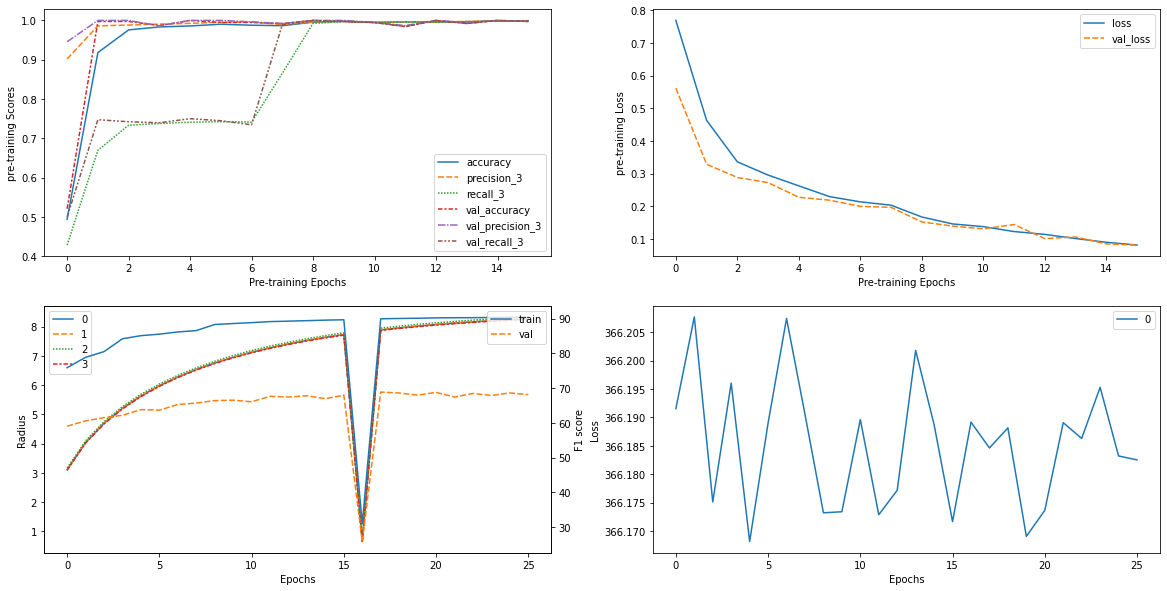

[[98  0  0  0  0]
 [ 0  0  0  0 92]
 [ 0  0 97  0  0]
 [ 0  0  0  2  0]
 [ 0  0  1  0 94]]
75.78
f1_weighted: 0.6772429243848282, f1_macro: 0.7327821881558536, f1_micro: 0.7578125, f_measure: {'Known': 74.8718, 'Open': 66.9039, 'F1-score': 73.2782}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        98
           1       0.00      0.00      0.00        92
           2       0.99      1.00      0.99        97
           3       1.00      1.00      1.00         2
           5       0.51      0.99      0.67        95

    accuracy                           0.76       384
   macro avg       0.70      0.80      0.73       384
weighted avg       0.64      0.76      0.68       384



In [5]:
comment="increasing logit size improved. will more pre-training help? "
test_data, oset, hist = oset_train(ablation=1000,designated_ukc_cls=5,num_classes=4,embedding_size=4,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=16, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1000
val_0:, 125
test_0:, 125
train_1:, 1000
val_1:, 125
test_1:, 125
train_2:, 1000
val_2:, 125
test_2:, 125
class 5 is added as ukc
ukc_5:, 125
vocab_size: 50
Epoch 1/16
93/93 [==============================] - 10s 100ms/step - loss: 0.5208 - accuracy: 0.7487 - precision_6: 0.9660 - recall_6: 0.5635 - val_loss: 0.0115 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 2/16
93/93 [==============================] - 9s 97ms/step - loss: 0.0131 - accuracy: 0.9976 - precision_6: 0.9980 - recall_6: 0.9976 - val_loss: 6.6155e-05 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 3/16
93/93 [==============================] - 9s 96ms/step - loss: 0.0073 - accuracy: 0.9976 - precision_6: 0.9976 - recall_6: 0.9976 - val_loss: 6.4819e-05 - val_accuracy

100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.02it/s]


epoch: 1/500, train_loss: 3.781235456466675, F1_train: 0.5046128758426842 F1_val: 0.4118217054263566


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 2/500, train_loss: 3.7892491817474365, F1_train: 0.5842506954984291 F1_val: 0.4113097213005972


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 3/500, train_loss: 3.783781051635742, F1_train: 0.6117880710854563 F1_val: 0.4085556653491436


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 4/500, train_loss: 3.7795944213867188, F1_train: 0.678005228606506 F1_val: 0.40224690082644626


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 5/500, train_loss: 3.7697973251342773, F1_train: 0.7571724453291457 F1_val: 0.6605051061273528


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.02it/s]


epoch: 6/500, train_loss: 3.7742092609405518, F1_train: 0.768984962116189 F1_val: 0.6676136363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  6.99it/s]


epoch: 7/500, train_loss: 3.7809343338012695, F1_train: 0.7847328369190373 F1_val: 0.6619318181818182


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.07it/s]


epoch: 8/500, train_loss: 3.778313398361206, F1_train: 0.8159193216926038 F1_val: 0.6732954545454546


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.09it/s]


epoch: 9/500, train_loss: 3.776836395263672, F1_train: 0.8552246268119156 F1_val: 0.6534090909090909


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.10it/s]


epoch: 10/500, train_loss: 3.77449369430542, F1_train: 0.8802984371561529 F1_val: 0.6704545454545454


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.11it/s]


epoch: 11/500, train_loss: 3.7747011184692383, F1_train: 0.8890975113532428 F1_val: 0.6676136363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 12/500, train_loss: 3.7779927253723145, F1_train: 0.8919018180543925 F1_val: 0.6676136363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.03it/s]


epoch: 13/500, train_loss: 3.781674861907959, F1_train: 0.8946961684882466 F1_val: 0.6732954545454546


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.03it/s]


epoch: 14/500, train_loss: 3.7797975540161133, F1_train: 0.8975496939486586 F1_val: 0.6619318181818182


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 15/500, train_loss: 3.778671979904175, F1_train: 0.8992576002070531 F1_val: 0.65625


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.05it/s]


epoch: 16/500, train_loss: 3.7726988792419434, F1_train: 0.8997119201318239 F1_val: 0.6761363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.03it/s]


epoch: 17/500, train_loss: 3.777135133743286, F1_train: 0.9019198849138234 F1_val: 0.65625


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.03it/s]


epoch: 18/500, train_loss: 3.7747437953948975, F1_train: 0.9030597076974394 F1_val: 0.6732954545454546


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.02it/s]


epoch: 19/500, train_loss: 3.7683298587799072, F1_train: 0.9033768566712178 F1_val: 0.6619318181818182


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  6.91it/s]


epoch: 20/500, train_loss: 3.7812018394470215, F1_train: 0.9037559107167067 F1_val: 0.6647727272727273


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  6.98it/s]


epoch: 21/500, train_loss: 3.7767584323883057, F1_train: 0.9055962349089703 F1_val: 0.6789772727272727


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  6.98it/s]


epoch: 22/500, train_loss: 3.7812891006469727, F1_train: 0.9067821136431315 F1_val: 0.6732954545454546


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.05it/s]


epoch: 23/500, train_loss: 3.7860240936279297, F1_train: 0.9076654336828621 F1_val: 0.6704545454545454


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.03it/s]


epoch: 24/500, train_loss: 3.7773234844207764, F1_train: 0.9077071846075573 F1_val: 0.6818181818181818


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.04it/s]


epoch: 25/500, train_loss: 3.7799324989318848, F1_train: 0.9075567883926589 F1_val: 0.65625


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.12it/s]


epoch: 26/500, train_loss: 3.7787699699401855, F1_train: 0.9082074032297287 F1_val: 0.6676136363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:12<00:00,  7.16it/s]


epoch: 27/500, train_loss: 3.77207350730896, F1_train: 0.9088285634379354 F1_val: 0.6676136363636364


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.15it/s]


epoch: 28/500, train_loss: 3.777695894241333, F1_train: 0.9080192634283728 F1_val: 0.6704545454545454


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  7.12it/s]


epoch: 29/500, train_loss: 3.763011932373047, F1_train: 0.9075985342301321 F1_val: 0.65625


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:14<00:00,  6.31it/s]


epoch: 30/500, train_loss: 3.7897932529449463, F1_train: 0.9084507733949405 F1_val: 0.6619318181818182


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:13<00:00,  6.99it/s]


epoch: 31/500, train_loss: 3.7863609790802, F1_train: 0.9089094172583244 F1_val: 0.6761363636363636


100%|██████████████████████████████████████████████████████████████████████████████████| 93/93 [00:16<00:00,  5.54it/s]


epoch: 32/500, train_loss: 3.7785847187042236, F1_train: 0.9091998883710342 F1_val: 0.6761363636363636


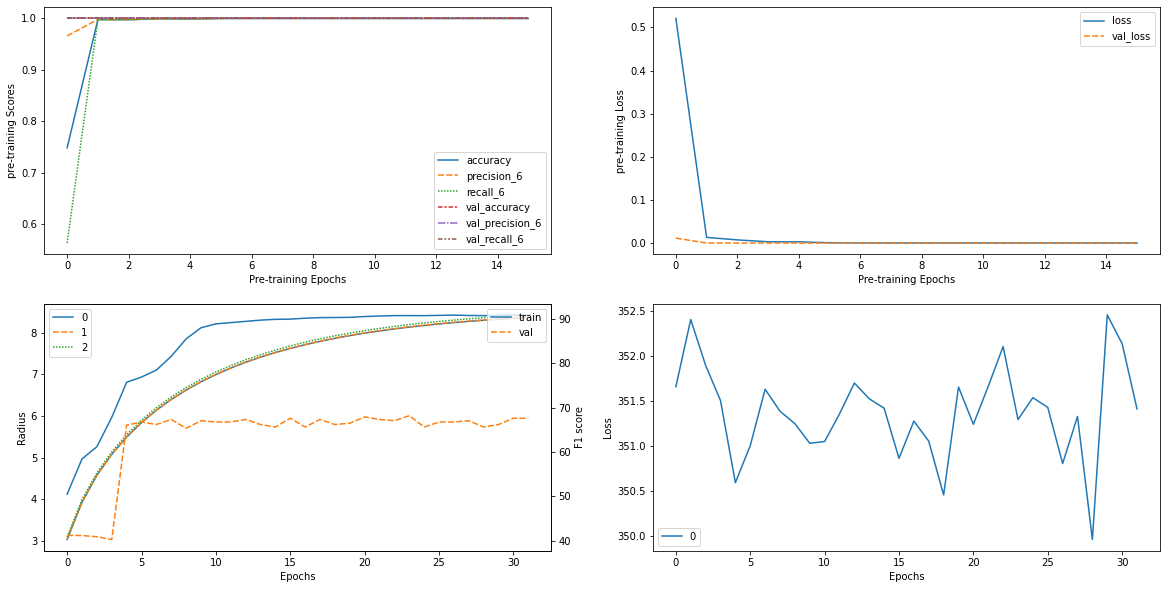

[[118   0   0   0]
 [  0   0   0 121]
 [  0   0 122   0]
 [ 24   7   0  88]]
68.33
f1_weighted: 0.6103361475922451, f1_macro: 0.6110694183864915, f1_micro: 0.6833333333333333, f_measure: {'Known': 63.5897, 'Open': 53.6585, 'F1-score': 61.1069}
              precision    recall  f1-score   support

           0       0.83      1.00      0.91       118
           1       0.00      0.00      0.00       121
           2       1.00      1.00      1.00       122
           5       0.42      0.74      0.54       119

    accuracy                           0.68       480
   macro avg       0.56      0.68      0.61       480
weighted avg       0.56      0.68      0.61       480



In [8]:
comment="last two cases are indicating overfit due to lack of data. lets increase data "
test_data, oset, hist = oset_train(ablation=1250,designated_ukc_cls=5,num_classes=3,embedding_size=4,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=16, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1200
val_0:, 150
test_0:, 150
train_1:, 1200
val_1:, 150
test_1:, 150
train_2:, 1200
val_2:, 150
test_2:, 150
class 5 is added as ukc
ukc_5:, 150
vocab_size: 50
Epoch 1/16
112/112 [==============================] - 12s 99ms/step - loss: 0.3483 - accuracy: 0.7824 - precision_7: 0.8739 - recall_7: 0.7252 - val_loss: 0.0117 - val_accuracy: 1.0000 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 2/16
112/112 [==============================] - 11s 98ms/step - loss: 0.0246 - accuracy: 0.9964 - precision_7: 0.9964 - recall_7: 0.9964 - val_loss: 0.0014 - val_accuracy: 1.0000 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 3/16
112/112 [==============================] - 11s 97ms/step - loss: 0.0256 - accuracy: 0.9908 - precision_7: 0.9908 - recall_7: 0.9908 - val_loss: 1.3039e-08 - val_accur

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.06it/s]


epoch: 1/500, train_loss: 13.870471000671387, F1_train: 0.13485151816998725 F1_val: 0.0653111471861472


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.88it/s]


epoch: 2/500, train_loss: 13.86070442199707, F1_train: 0.3028799168845283 F1_val: 0.28363686657576503


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.15it/s]


epoch: 3/500, train_loss: 13.847646713256836, F1_train: 0.39349235327272314 F1_val: 0.35266919513933176


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.12it/s]


epoch: 4/500, train_loss: 13.862303733825684, F1_train: 0.4081034897879343 F1_val: 0.35499278264108775


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.15it/s]


epoch: 5/500, train_loss: 13.86462688446045, F1_train: 0.4129983519916645 F1_val: 0.35722495097495105


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.09it/s]


epoch: 6/500, train_loss: 13.85355281829834, F1_train: 0.4194637389420187 F1_val: 0.35722495097495105


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.94it/s]


epoch: 7/500, train_loss: 13.857535362243652, F1_train: 0.4218540762657322 F1_val: 0.36057027649769585


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.96it/s]


epoch: 8/500, train_loss: 13.873919486999512, F1_train: 0.4243748908182079 F1_val: 0.3605769230769231


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.18it/s]


epoch: 9/500, train_loss: 13.860282897949219, F1_train: 0.4264076178573809 F1_val: 0.36057027649769585


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.19it/s]


epoch: 10/500, train_loss: 13.862568855285645, F1_train: 0.427899754383469 F1_val: 0.36649525316455694


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.18it/s]


epoch: 11/500, train_loss: 13.865628242492676, F1_train: 0.42905571165208534 F1_val: 0.3687042124542125


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.19it/s]


epoch: 12/500, train_loss: 13.826936721801758, F1_train: 0.4303788435068937 F1_val: 0.3624370421245421


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 13/500, train_loss: 13.84641170501709, F1_train: 0.43128232843395686 F1_val: 0.3687042124542125


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.95it/s]


epoch: 14/500, train_loss: 13.839476585388184, F1_train: 0.431373504589687 F1_val: 0.36649525316455694


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.87it/s]


epoch: 15/500, train_loss: 13.861574172973633, F1_train: 0.43049200232816087 F1_val: 0.3687273960216998


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.11it/s]


epoch: 16/500, train_loss: 13.860069274902344, F1_train: 0.43219811945276365 F1_val: 0.3687273960216998


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.20it/s]


epoch: 17/500, train_loss: 13.857779502868652, F1_train: 0.43271674371849134 F1_val: 0.3642631103074141


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.14it/s]


epoch: 18/500, train_loss: 13.8460111618042, F1_train: 0.4351088105718121 F1_val: 0.3642631103074141


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.18it/s]


epoch: 19/500, train_loss: 13.843653678894043, F1_train: 0.4340861273978386 F1_val: 0.3687273960216998


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.16it/s]


epoch: 20/500, train_loss: 13.844603538513184, F1_train: 0.43502924170324875 F1_val: 0.36649525316455694


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.18it/s]


epoch: 21/500, train_loss: 13.853339195251465, F1_train: 0.43449924469260265 F1_val: 0.36649525316455694


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 22/500, train_loss: 13.8626708984375, F1_train: 0.43547290898647834 F1_val: 0.3687158780709736


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.11it/s]


epoch: 23/500, train_loss: 13.853825569152832, F1_train: 0.4348817817887514 F1_val: 0.36648373521383076


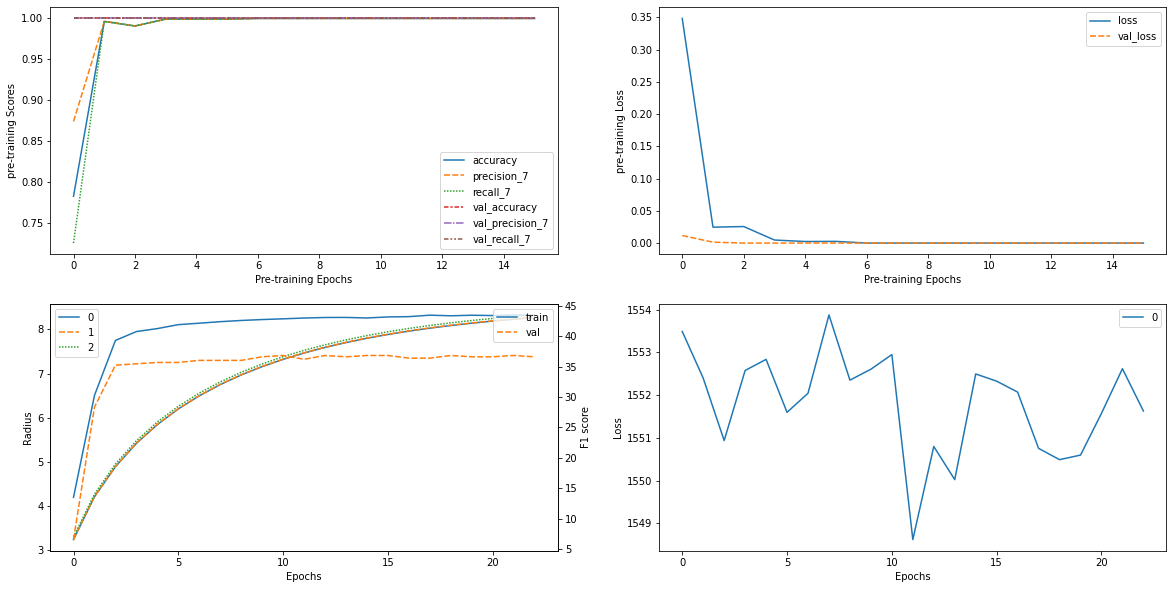

[[142   0   0   0]
 [  0   0   0 147]
 [  0   0  20 124]
 [  0   0   0 143]]
52.95
f1_weighted: 0.434978203013628, f1_macro: 0.4393418575119324, f1_micro: 0.5295138888888888, f_measure: {'Known': 41.4634, 'Open': 51.3465, 'F1-score': 43.9342}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       0.00      0.00      0.00       147
           2       1.00      0.14      0.24       144
           5       0.35      1.00      0.51       143

    accuracy                           0.53       576
   macro avg       0.59      0.53      0.44       576
weighted avg       0.58      0.53      0.43       576



In [9]:
comment="overfit still exists, lets increase data "
test_data, oset, hist = oset_train(ablation=1500,designated_ukc_cls=5,num_classes=3,embedding_size=4,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=16, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1200
val_0:, 150
test_0:, 150
train_1:, 1200
val_1:, 150
test_1:, 150
train_2:, 1200
val_2:, 150
test_2:, 150
class 5 is added as ukc
ukc_5:, 150
vocab_size: 50
Epoch 1/6
112/112 [==============================] - 12s 99ms/step - loss: 0.1969 - accuracy: 0.8934 - precision_9: 0.9944 - recall_9: 0.8438 - val_loss: 8.8347e-06 - val_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.0000
Epoch 2/6
112/112 [==============================] - 11s 101ms/step - loss: 0.0044 - accuracy: 0.9989 - precision_9: 0.9989 - recall_9: 0.9989 - val_loss: 2.6619e-04 - val_accuracy: 1.0000 - val_precision_9: 1.0000 - val_recall_9: 1.0000
Epoch 3/6
112/112 [==============================] - 11s 97ms/step - loss: 0.0062 - accuracy: 0.9983 - precision_9: 0.9983 - recall_9: 0.9983 - val_loss: 4.1417e-05 - val

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 1/500, train_loss: 9.976229667663574, F1_train: 0.3564176506687419 F1_val: 0.3799603174603175


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 2/500, train_loss: 9.962554931640625, F1_train: 0.37694246523282343 F1_val: 0.3919533304119193


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.06it/s]


epoch: 3/500, train_loss: 9.961627006530762, F1_train: 0.42828049400166684 F1_val: 0.39932359307359305


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.85it/s]


epoch: 4/500, train_loss: 9.972844123840332, F1_train: 0.4509169095950272 F1_val: 0.4170582706766917


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 5/500, train_loss: 9.969354629516602, F1_train: 0.4664862467943678 F1_val: 0.41824127906976744


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 6/500, train_loss: 9.970885276794434, F1_train: 0.6012052000792225 F1_val: 0.6497885338345865


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.97it/s]


epoch: 7/500, train_loss: 9.957837104797363, F1_train: 0.6061012288393332 F1_val: 0.6534598214285714


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.02it/s]


epoch: 8/500, train_loss: 9.954996109008789, F1_train: 0.6083499735862172 F1_val: 0.6546633897461424


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 9/500, train_loss: 9.960037231445312, F1_train: 0.6122922721818738 F1_val: 0.6548189397710303


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 10/500, train_loss: 9.9650239944458, F1_train: 0.6160960933524636 F1_val: 0.6582358374384236


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.09it/s]


epoch: 11/500, train_loss: 9.959060668945312, F1_train: 0.6182462453561477 F1_val: 0.6594115675280351


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 12/500, train_loss: 9.945456504821777, F1_train: 0.6194256292232726 F1_val: 0.6571781418753069


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 13/500, train_loss: 9.967154502868652, F1_train: 0.6208977079086796 F1_val: 0.6594102847324497


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.09it/s]


epoch: 14/500, train_loss: 9.957342147827148, F1_train: 0.6217781758988364 F1_val: 0.6583435960591133


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 15/500, train_loss: 9.966259956359863, F1_train: 0.6217427816229206 F1_val: 0.6583454810495627


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.06it/s]


epoch: 16/500, train_loss: 9.963513374328613, F1_train: 0.6223040396582382 F1_val: 0.659503631961259


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.01it/s]


epoch: 17/500, train_loss: 9.94654369354248, F1_train: 0.6247385999906884 F1_val: 0.6628856899902819


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.03it/s]


epoch: 18/500, train_loss: 9.961106300354004, F1_train: 0.6242929783998846 F1_val: 0.6628856899902819


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.03it/s]


epoch: 19/500, train_loss: 9.946272850036621, F1_train: 0.6242770703105653 F1_val: 0.6606531311154599


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.09it/s]


epoch: 20/500, train_loss: 9.962821006774902, F1_train: 0.6239189021525297 F1_val: 0.6629314477468841


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 21/500, train_loss: 9.969616889953613, F1_train: 0.624197647361461 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.06it/s]


epoch: 22/500, train_loss: 9.958529472351074, F1_train: 0.6243170576578994 F1_val: 0.6685230530339226


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.04it/s]


epoch: 23/500, train_loss: 9.954255104064941, F1_train: 0.6245560111970965 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 24/500, train_loss: 9.946497917175293, F1_train: 0.6241893872482167 F1_val: 0.6640587673196369


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.06it/s]


epoch: 25/500, train_loss: 9.95468807220459, F1_train: 0.6245719008614791 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:17<00:00,  6.58it/s]


epoch: 26/500, train_loss: 9.969832420349121, F1_train: 0.6243098991010225 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:17<00:00,  6.46it/s]


epoch: 27/500, train_loss: 9.954126358032227, F1_train: 0.6244767078783232 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.21it/s]


epoch: 28/500, train_loss: 9.966171264648438, F1_train: 0.6243890344112183 F1_val: 0.6685230530339226


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.29it/s]


epoch: 29/500, train_loss: 9.963166236877441, F1_train: 0.6254241579856734 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.13it/s]


epoch: 30/500, train_loss: 9.966301918029785, F1_train: 0.6253038499724413 F1_val: 0.6662909101767797


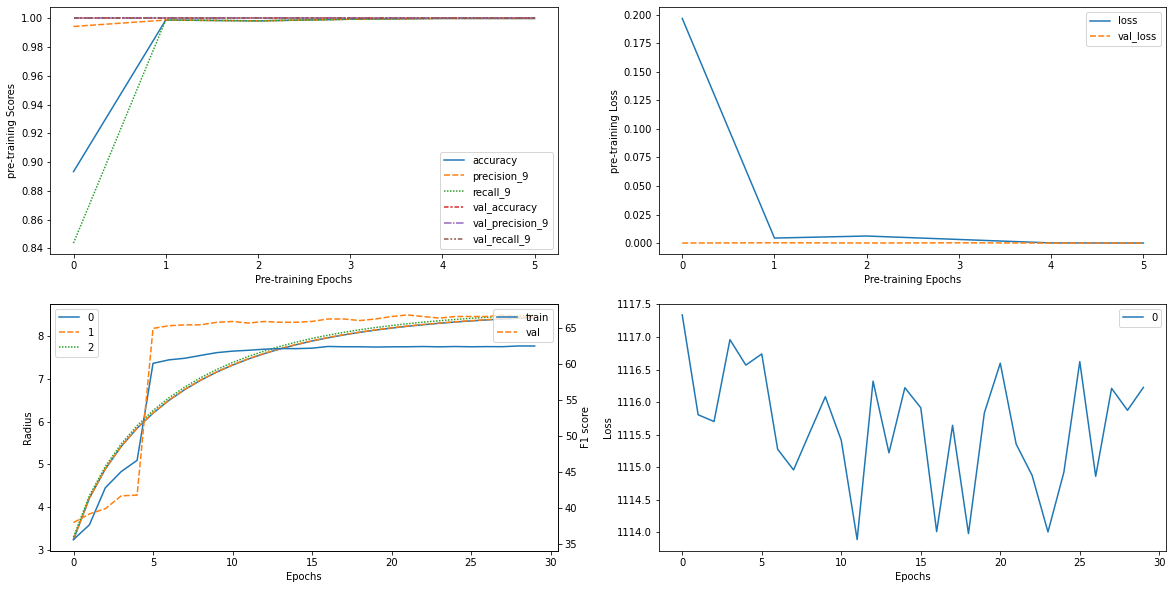

[[142   0   0   0]
 [  0   0   0 147]
 [  0   0 113  31]
 [ 18   0   0 125]]
65.97
f1_weighted: 0.5908397998407255, f1_macro: 0.5950782248729801, f1_micro: 0.6597222222222222, f_measure: {'Known': 60.6592, 'Open': 56.0538, 'F1-score': 59.5078}
              precision    recall  f1-score   support

           0       0.89      1.00      0.94       142
           1       0.00      0.00      0.00       147
           2       1.00      0.78      0.88       144
           5       0.41      0.87      0.56       143

    accuracy                           0.66       576
   macro avg       0.58      0.66      0.60       576
weighted avg       0.57      0.66      0.59       576



In [11]:
comment="overfit solved but with radius 8, most of the data points are outside it seems. Should increase the embedding size ?"
test_data, oset, hist = oset_train(ablation=1500,designated_ukc_cls=5,num_classes=3,embedding_size=6,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1200
val_0:, 150
test_0:, 150
train_1:, 1200
val_1:, 150
test_1:, 150
train_2:, 1200
val_2:, 150
test_2:, 150
class 5 is added as ukc
ukc_5:, 150
vocab_size: 50
Epoch 1/6
112/112 [==============================] - 12s 101ms/step - loss: 0.1813 - accuracy: 0.9046 - precision_10: 0.9803 - recall_10: 0.8630 - val_loss: 1.4403e-04 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 1.0000
Epoch 2/6
112/112 [==============================] - 11s 98ms/step - loss: 0.0103 - accuracy: 0.9980 - precision_10: 0.9983 - recall_10: 0.9980 - val_loss: 4.3076e-05 - val_accuracy: 1.0000 - val_precision_10: 1.0000 - val_recall_10: 1.0000
Epoch 3/6
112/112 [==============================] - 11s 101ms/step - loss: 0.0029 - accuracy: 0.9997 - precision_10: 0.9997 - recall_10: 0.9997 - val_loss: 5.568

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.05it/s]


epoch: 1/500, train_loss: 4.580014705657959, F1_train: 0.4341740324199018 F1_val: 0.4091386554621849


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.04it/s]


epoch: 2/500, train_loss: 4.569056034088135, F1_train: 0.4845340242485433 F1_val: 0.4524220599842147


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 3/500, train_loss: 4.5728631019592285, F1_train: 0.6205894614169863 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 4/500, train_loss: 4.57745361328125, F1_train: 0.6309650386864204 F1_val: 0.6685230530339226


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 5/500, train_loss: 4.576030731201172, F1_train: 0.6364444998215084 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 6/500, train_loss: 4.577085971832275, F1_train: 0.6652464709472345 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.08it/s]


epoch: 7/500, train_loss: 4.569888114929199, F1_train: 0.6722362013477561 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 8/500, train_loss: 4.569975852966309, F1_train: 0.6800051587814995 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.75it/s]


epoch: 9/500, train_loss: 4.571618556976318, F1_train: 0.6928661554690566 F1_val: 0.6640587167070218


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.78it/s]


epoch: 10/500, train_loss: 4.5752787590026855, F1_train: 0.7011983593612553 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.92it/s]


epoch: 11/500, train_loss: 4.57111120223999, F1_train: 0.7076933718987609 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  7.00it/s]


epoch: 12/500, train_loss: 4.566969871520996, F1_train: 0.7107522769554986 F1_val: 0.6640587421837422


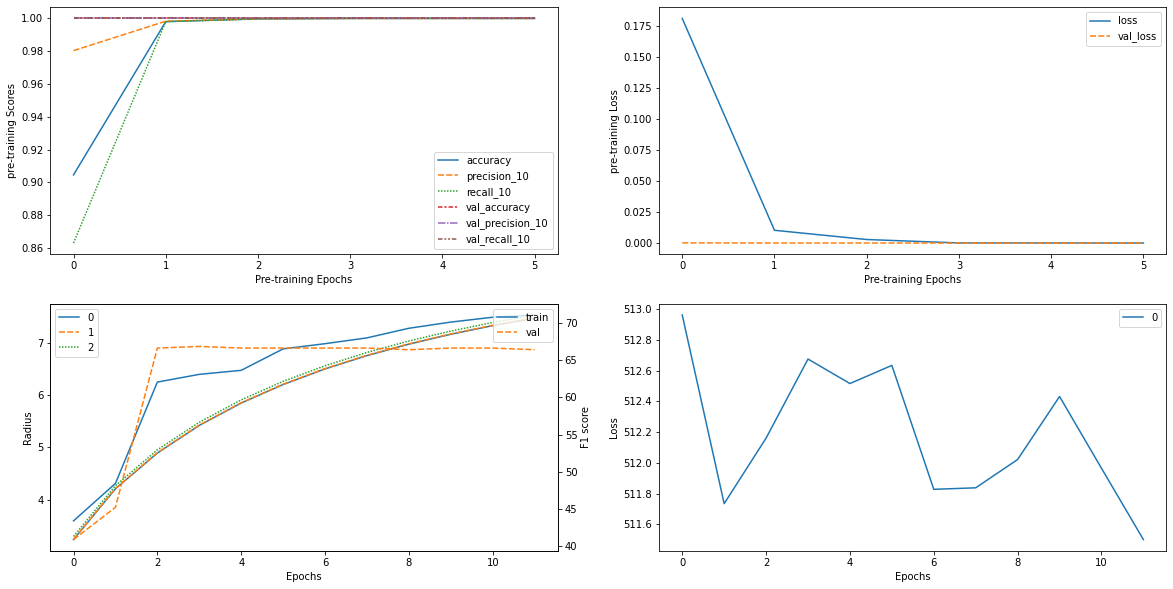

[[142   0   0   0]
 [  0   0   0 147]
 [  0   0 117  27]
 [  0   0   0 143]]
69.79
f1_weighted: 0.6250210832083958, f1_macro: 0.6295727136431783, f1_micro: 0.6979166666666666, f_measure: {'Known': 63.2184, 'Open': 62.1739, 'F1-score': 62.9573}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       142
           1       0.00      0.00      0.00       147
           2       1.00      0.81      0.90       144
           5       0.45      1.00      0.62       143

    accuracy                           0.70       576
   macro avg       0.61      0.70      0.63       576
weighted avg       0.61      0.70      0.63       576



In [12]:
comment="embedding size increase improved f1 . Lets increase more  ?"
test_data, oset, hist = oset_train(ablation=1500,designated_ukc_cls=5,num_classes=3,embedding_size=8,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1200
val_0:, 150
test_0:, 150
train_1:, 1200
val_1:, 150
test_1:, 150
train_2:, 1200
val_2:, 150
test_2:, 150
class 5 is added as ukc
ukc_5:, 150
vocab_size: 50
Epoch 1/6
112/112 [==============================] - 12s 99ms/step - loss: 0.1302 - accuracy: 0.9453 - precision_11: 0.9803 - recall_11: 0.9180 - val_loss: 2.8863e-04 - val_accuracy: 1.0000 - val_precision_11: 1.0000 - val_recall_11: 1.0000
Epoch 2/6
112/112 [==============================] - 11s 97ms/step - loss: 0.0106 - accuracy: 0.9980 - precision_11: 0.9980 - recall_11: 0.9980 - val_loss: 1.9404e-04 - val_accuracy: 1.0000 - val_precision_11: 1.0000 - val_recall_11: 1.0000
Epoch 3/6
112/112 [==============================] - 11s 97ms/step - loss: 8.4850e-04 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - val_loss: 2.7

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.14it/s]


epoch: 1/500, train_loss: 4.139433860778809, F1_train: 0.5841641075594575 F1_val: 0.6412627551020408


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.14it/s]


epoch: 2/500, train_loss: 4.132397174835205, F1_train: 0.6048734673314147 F1_val: 0.6546633897461424


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.19it/s]


epoch: 3/500, train_loss: 4.1323041915893555, F1_train: 0.6304860377347076 F1_val: 0.6617351292052659


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.22it/s]


epoch: 4/500, train_loss: 4.137772560119629, F1_train: 0.6595362866989759 F1_val: 0.6685230530339226


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.23it/s]


epoch: 5/500, train_loss: 4.134083271026611, F1_train: 0.6642485817439192 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.21it/s]


epoch: 6/500, train_loss: 4.136806964874268, F1_train: 0.7157524894180162 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.05it/s]


epoch: 7/500, train_loss: 4.131730556488037, F1_train: 0.7404405394391423 F1_val: 0.6662909101767797


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.05it/s]


epoch: 8/500, train_loss: 4.130697727203369, F1_train: 0.7476602670525958 F1_val: 0.6662908850408851


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.89it/s]


epoch: 9/500, train_loss: 4.132625579833984, F1_train: 0.7526333456463173 F1_val: 0.6640587167070218


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.12it/s]


epoch: 10/500, train_loss: 4.133151531219482, F1_train: 0.7552601284661417 F1_val: 0.6674107142857143


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.09it/s]


epoch: 11/500, train_loss: 4.132575035095215, F1_train: 0.756773436046184 F1_val: 0.6674107142857143


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 12/500, train_loss: 4.127110004425049, F1_train: 0.7566718932371543 F1_val: 0.6651785714285714


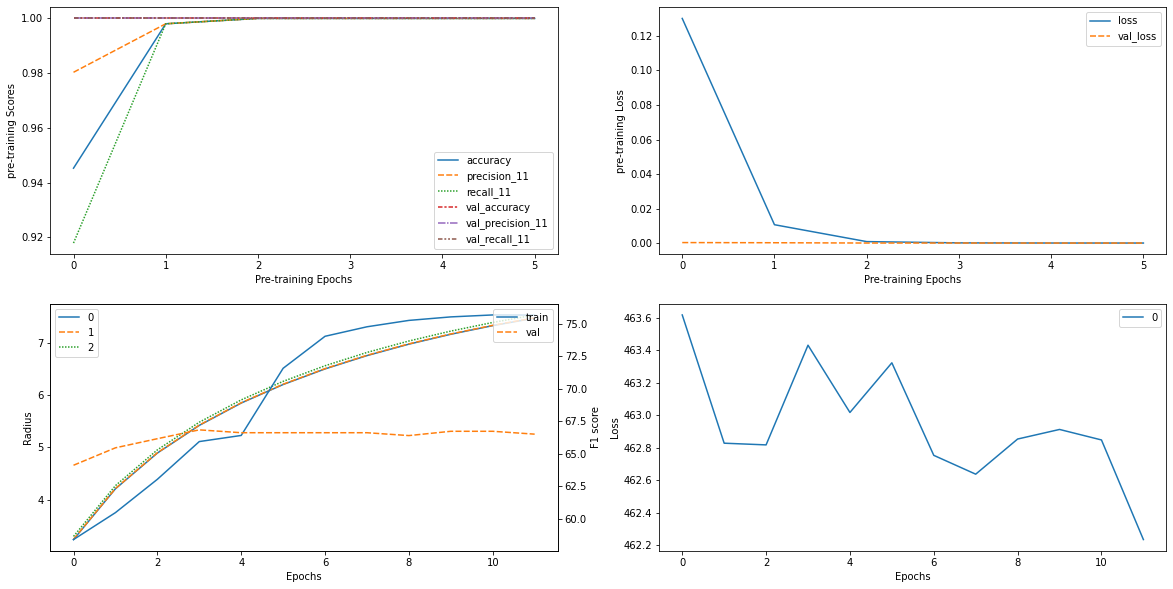

[[142   0   0   0]
 [  0   0   0 147]
 [  0   0 121  23]
 [  3   0   0 140]]
69.97
f1_weighted: 0.6257050125108751, f1_macro: 0.6302140326878002, f1_micro: 0.6996527777777778, f_measure: {'Known': 63.4252, 'Open': 61.8102, 'F1-score': 63.0214}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       142
           1       0.00      0.00      0.00       147
           2       1.00      0.84      0.91       144
           5       0.45      0.98      0.62       143

    accuracy                           0.70       576
   macro avg       0.61      0.70      0.63       576
weighted avg       0.60      0.70      0.63       576



In [13]:
comment=" Lets increase more  ?"
test_data, oset, hist = oset_train(ablation=1500,designated_ukc_cls=5,num_classes=3,embedding_size=12,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 1200
val_0:, 150
test_0:, 150
train_1:, 1200
val_1:, 150
test_1:, 150
train_2:, 1200
val_2:, 150
test_2:, 150
class 5 is added as ukc
ukc_5:, 150
vocab_size: 50
Epoch 1/6
112/112 [==============================] - 13s 108ms/step - loss: 0.1732 - accuracy: 0.9283 - precision_12: 0.9878 - recall_12: 0.8820 - val_loss: 0.0060 - val_accuracy: 1.0000 - val_precision_12: 1.0000 - val_recall_12: 1.0000
Epoch 2/6
112/112 [==============================] - 11s 97ms/step - loss: 0.0069 - accuracy: 0.9986 - precision_12: 0.9986 - recall_12: 0.9983 - val_loss: 0.0015 - val_accuracy: 1.0000 - val_precision_12: 1.0000 - val_recall_12: 1.0000
Epoch 3/6
112/112 [==============================] - 11s 97ms/step - loss: 0.0062 - accuracy: 0.9992 - precision_12: 0.9992 - recall_12: 0.9992 - val_loss: 4.4623e-05 - v

100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.20it/s]


epoch: 1/500, train_loss: 5.337563991546631, F1_train: 0.5294044165487346 F1_val: 0.6251998933901918


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.17it/s]


epoch: 2/500, train_loss: 5.3298139572143555, F1_train: 0.5469957770922408 F1_val: 0.6356190913865546


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.19it/s]


epoch: 3/500, train_loss: 5.327491283416748, F1_train: 0.5602415944268062 F1_val: 0.634274512387981


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.19it/s]


epoch: 4/500, train_loss: 5.3349833488464355, F1_train: 0.5742777168774797 F1_val: 0.636528649921507


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.20it/s]


epoch: 5/500, train_loss: 5.32849645614624, F1_train: 0.5815370684246878 F1_val: 0.6342965070643641


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.01it/s]


epoch: 6/500, train_loss: 5.330795764923096, F1_train: 0.5933973735105903 F1_val: 0.6396096570397111


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.04it/s]


epoch: 7/500, train_loss: 5.327547550201416, F1_train: 0.6089687307214984 F1_val: 0.6434948979591837


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.28it/s]


epoch: 8/500, train_loss: 5.329367160797119, F1_train: 0.6183300255424171 F1_val: 0.6447612647209421


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 9/500, train_loss: 5.328125953674316, F1_train: 0.6283725246424006 F1_val: 0.6425186952037133


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.25it/s]


epoch: 10/500, train_loss: 5.330559253692627, F1_train: 0.6369802602987745 F1_val: 0.6447612647209421


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.07it/s]


epoch: 11/500, train_loss: 5.326645374298096, F1_train: 0.6498751779057602 F1_val: 0.6447715429588206


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.16it/s]


epoch: 12/500, train_loss: 5.320805549621582, F1_train: 0.6666921700844952 F1_val: 0.6463082573454914


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.18it/s]


epoch: 13/500, train_loss: 5.331984519958496, F1_train: 0.6765978545909667 F1_val: 0.6510154678068412


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.11it/s]


epoch: 14/500, train_loss: 5.329236030578613, F1_train: 0.6817294076389118 F1_val: 0.6512198189134809


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.10it/s]


epoch: 15/500, train_loss: 5.332813739776611, F1_train: 0.6838956776989361 F1_val: 0.6512276785714286


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.28it/s]


epoch: 16/500, train_loss: 5.325884819030762, F1_train: 0.686492273053653 F1_val: 0.6536330049261084


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.27it/s]


epoch: 17/500, train_loss: 5.317019939422607, F1_train: 0.6906592099038079 F1_val: 0.6558624751984128


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.29it/s]


epoch: 18/500, train_loss: 5.326535701751709, F1_train: 0.6921545618330386 F1_val: 0.6558624751984128


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.27it/s]


epoch: 19/500, train_loss: 5.320740699768066, F1_train: 0.6934357322797327 F1_val: 0.6536276223776224


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.28it/s]


epoch: 20/500, train_loss: 5.330901145935059, F1_train: 0.6952630817176326 F1_val: 0.6536330049261084


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:16<00:00,  6.93it/s]


epoch: 21/500, train_loss: 5.33406400680542, F1_train: 0.6979013001334674 F1_val: 0.6570532624814632


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.25it/s]


epoch: 22/500, train_loss: 5.324851989746094, F1_train: 0.6989325423845834 F1_val: 0.6592875552282769


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.27it/s]


epoch: 23/500, train_loss: 5.320440769195557, F1_train: 0.7005361088262217 F1_val: 0.6582375244618396


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.25it/s]


epoch: 24/500, train_loss: 5.317415714263916, F1_train: 0.7024106331633303 F1_val: 0.6560053816046967


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.21it/s]


epoch: 25/500, train_loss: 5.324933052062988, F1_train: 0.7023328510794491 F1_val: 0.6582375244618396


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.31it/s]


epoch: 26/500, train_loss: 5.330458641052246, F1_train: 0.7030698371844206 F1_val: 0.6582375244618396


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.32it/s]


epoch: 27/500, train_loss: 5.324593544006348, F1_train: 0.7032207393913011 F1_val: 0.6594102847324497


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.32it/s]


epoch: 28/500, train_loss: 5.33302640914917, F1_train: 0.7037066235554634 F1_val: 0.661643710385178


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.38it/s]


epoch: 29/500, train_loss: 5.326090335845947, F1_train: 0.7040593442487355 F1_val: 0.6594102847324497


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.36it/s]


epoch: 30/500, train_loss: 5.332436561584473, F1_train: 0.7043326707980304 F1_val: 0.6594115675280351


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.38it/s]


epoch: 31/500, train_loss: 5.327424049377441, F1_train: 0.7040849263542002 F1_val: 0.6571768413247653


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.33it/s]


epoch: 32/500, train_loss: 5.334475517272949, F1_train: 0.7050887944484011 F1_val: 0.6571781418753069


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.26it/s]


epoch: 33/500, train_loss: 5.336976528167725, F1_train: 0.7040854260967445 F1_val: 0.6571768413247653


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.36it/s]


epoch: 34/500, train_loss: 5.3329973220825195, F1_train: 0.7046629074629455 F1_val: 0.6594115675280351


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.41it/s]


epoch: 35/500, train_loss: 5.329206943511963, F1_train: 0.7055168832905174 F1_val: 0.661643710385178


100%|████████████████████████████████████████████████████████████████████████████████| 112/112 [00:15<00:00,  7.39it/s]


epoch: 36/500, train_loss: 5.338908672332764, F1_train: 0.7056206917998293 F1_val: 0.661643710385178


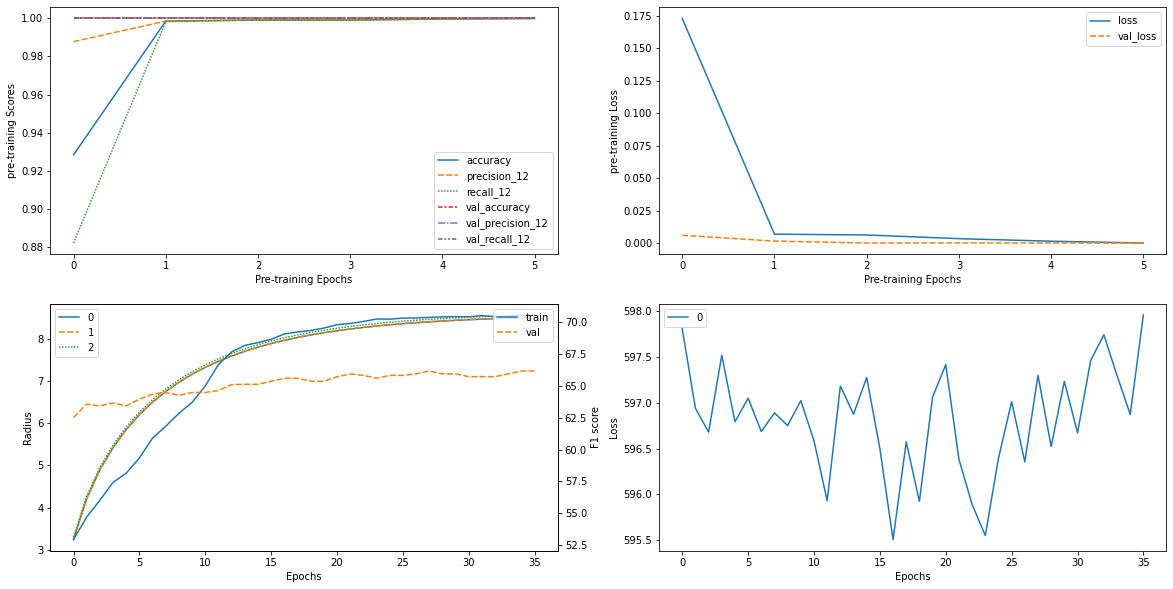

[[142   0   0   0]
 [  0   0   0 147]
 [  0   0  81  63]
 [ 35   0   0 108]]
57.47
f1_weighted: 0.5158024859259058, f1_macro: 0.5197071923513692, f1_micro: 0.5746527777777778, f_measure: {'Known': 53.6761, 'Open': 46.8547, 'F1-score': 51.9707}
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       142
           1       0.00      0.00      0.00       147
           2       1.00      0.56      0.72       144
           5       0.34      0.76      0.47       143

    accuracy                           0.57       576
   macro avg       0.54      0.58      0.52       576
weighted avg       0.53      0.57      0.52       576



In [14]:
comment=" Lets increase more  ?"
test_data, oset, hist = oset_train(ablation=1500,designated_ukc_cls=5,num_classes=3,embedding_size=16,
                             lr_rate=2.5, optimizer='adam',
pretrain_epochs=6, wait_patient=8, comment=comment)